### Import all the useful libs

In [101]:
import plotly.offline as ply
ply.init_notebook_mode(connected=True)

import numpy as np
import scipy as sp
import pandas as pd
from scipy.special import binom
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly
import pandas as pd
import mpnum as mp
import sklearn

from sklearn import svm
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from numba import autojit

import plotly.plotly as py
from plotly.graph_objs import *
%load_ext line_profiler
#%matplotlib notebook

# Sweeeeeping!!

Define Ausiliar functions

In [136]:
@autojit
def feature_map(x):
    """Local feature map"""
    
    x_arr = 0.5 * np.pi * np.array([x]*d)
    s = np.arange(d)
    return np.sqrt(binom([d-1]*d,s)) * np.power(np.cos(x_arr), d-1-s) * np.power(np.sin(x_arr), s)

@autojit
def Tdelta(l):
    """Create a tensor kronecker delta"""
    return mp.MPArray.from_kron([np.array([1-l,l])])

@autojit
def evaluate(Tweight, x, y):
    """ Evaluate the tensor network and train the tensor """
    xy_mpa = mp.MPArray.from_kron([feature_map(x),feature_map(y)]).group_sites(2) # feature tensor
    Tf = mp.dot(Tweight,xy_mpa,axes=([1,2],[0,1]))
    W0 = mp.dot(Tf, Tdelta(0)).to_array()
    W1 = mp.dot(Tf, Tdelta(1)).to_array()
    Wdiff = W0 - W1
    Wsum = W0 + W1
    return Wdiff * Wsum / np.abs(Wdiff * Wsum)

#Vectorize the tn evaluate function so that can handle arrays 
vector_evaluate=np.vectorize(evaluate,excluded=['Tweight'])

def tn_score(Tweight,data,label):
    """ Evaluate the performance of the TN"""
    score=0
    classified=(vector_evaluate(Tweight,data.T[0],data.T[1]))
    for i,j in enumerate(classified):
        #Convert from notation +-1 to +1,0
        if( -1*((j-1)/2.)==label[i]):
            score=score+1
    return float(score)/len(classified)

def plot_tn_decision_function(Tweight, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 100)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 100)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] =evaluate(Tweight,xi,yj)
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 100)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 100)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function(np.c_[xi.ravel(), yj.ravel()])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
def plot_nb_decision_function(clf, ax=None):
    """Plot the decision function for naive bayes classifier"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 100)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 100)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            prediction=clf.predict_proba(np.c_[xi.ravel(), yj.ravel()])
            #print(prediction)
            if(prediction[0][0]>prediction[0][1]):
                P[i, j] = 1
            else: 
                P[i, j] = -1
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

Define sweeping algorithm

In [151]:
@autojit
def update2sites(data, label, Tweight):    
    TdeltaB = mp.MPArray.from_kron([np.array([0]*2), np.array([0]*d), np.array([0]*d)]).group_sites(3) #null tensor deltaB (single size)
    for idx in range(len(data)):
        # create the full feature map
        xy_mpa = mp.MPArray.from_kron([feature_map(data[idx][0]),feature_map(data[idx][1])]).group_sites(2) # feature tensor
        # tensot product between the weights and the feature map
        Tf = mp.dot(Tweight,xy_mpa,axes=([1,2],[0,1])) # the last two physical legs are of Tweight are contracted with the feature tensor
        Tcoef = (Tdelta(label[idx]) - Tf)
        Ttemp = mp.MPArray.from_kron([Tcoef.to_array(), xy_mpa.to_array()]).group_sites(2)
        TdeltaB = TdeltaB + Ttemp
    
    Tweight = Tweight + alpha * TdeltaB
    return Tweight

Define the class for the Gaussian Naive Bayes

In [152]:
class nbayes:
    """This class implements the Naive Bayes Classifier for our data """
    def __init__(self):
        i = 0

    def learn(self, data, label):
        data_temp = np.array(data)
        label_temp = np.array(label)
        self.index0 = np.where(label == 0)
        self.index1 = np.where(label == 1)
        self.meanx0 = (data_temp[self.index0].T[0]).mean()
        self.meany0 = (data_temp[self.index0].T[1]).mean()
        self.varx0 = (data_temp[self.index0].T[0]).var()
        self.vary0 = (data_temp[self.index0].T[1]).var()
        self.meanx1 = (data_temp[self.index1].T[0]).mean()
        self.meany1 = (data_temp[self.index1].T[1]).mean()
        self.varx1 = (data_temp[self.index1].T[0]).var()
        self.vary1 = (data_temp[self.index1].T[1]).var()
        self.p0 =  (len(self.index0[0]))/float(len(data_temp))
        self.p1 = (len(self.index1[0]))/float(len(data_temp))
        #print((self.p0))
        #print((self.p1))

    def classify(self, data):
        pr0 = self.p0 * self.gauss(data[0], self.meanx0, self.varx0) * \
            self.gauss(data[1], self.meany0, self.vary0)
        pr1 = self.p1 * self.gauss(data[0], self.meanx1, self.varx1) * \
            self.gauss(data[1], self.meany1, self.vary1)
        normalization=pr0+pr1
        pr0=pr0/normalization
        pr1=pr1/normalization
        if(pr0 > pr1):
            return 0
        else:
            return 1

    def gauss(self, x, mean, var):
        return ((1. / (np.sqrt(2 * np.pi * var))) * np.exp(-1*((x - mean)**2) / (2. * var)))

    def score(self, data, label):
        right = 0
        for i in range(0, len(data)):
            if(self.classify(data[i]) == label[i]):
                right = right + 1
        print(("Percentage: " + str(float(right) / float(len(data)))))
        return float(right) / float(len(data))
    
    def predict_proba(self,data):
        self.data=np.array(data)[0]
        pr0 = self.p0 * self.gauss(self.data[0], self.meanx0, self.varx0) * \
            self.gauss(self.data[1], self.meany0, self.vary0)
        pr1 = self.p1 * self.gauss(self.data[0], self.meanx1, self.varx1) * \
            self.gauss(self.data[1], self.meany1, self.vary1)
        return([np.array([pr0,pr1])])

# Classify data

## Two overlapping  gaussians

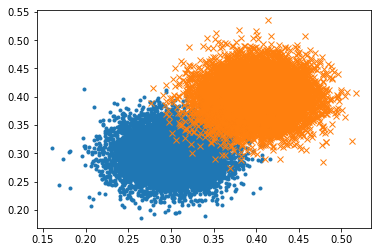

In [153]:
mean1=[0.3,0.3]
cov1=[[0.001,0],[0,0.001]]
mean2=[0.4,0.4]
cov2=[[0.001,0],[0,0.001]]
class0_learning=np.random.multivariate_normal(mean1, cov1, 10000)
class1_learning=np.random.multivariate_normal(mean2, cov2, 10000)

class0_validate=np.random.multivariate_normal(mean1, cov1, 10000)
class1_validate=np.random.multivariate_normal(mean2, cov2, 10000)

f1=plt.figure()
plt.plot(class0_learning.T[0],class0_learning.T[1],".")
plt.plot(class1_learning.T[0],class1_learning.T[1],"x")
plt.show()

Prepare training data

In [241]:
# set data
numdata = 1000
train_data = np.concatenate([class0_learning[0:numdata], class1_learning[0:numdata]])
label = np.concatenate([np.array([0]*numdata), np.array([1]*numdata)])

validate_data=np.concatenate([class0_validate[0:numdata], class1_validate[0:numdata]])
label_validate=np.concatenate([np.array([0]*numdata), np.array([1]*numdata)])



### Tensor network

Generate and update a random tensor weight using gradient descent steps

In [155]:
d = 2 # local dimension
rng = np.random.RandomState(seed=143)
Tweight = mp.random_mpa(sites=1, ldim=[[2,d,d]], bdim=1, randstate=rng, normalized=True)

In [156]:
numsteps = 100
alpha = 5e-4 # control convergence

for idx in range(numsteps):
    Tweight = update2sites(train_data, label, Tweight)

In [157]:
tn_scored=tn_score(Tweight,validate_data,label_validate)
print("TN Classification fidelity: "+str(tn_scored))

TN Classification fidelity: 0.9925


Plot results

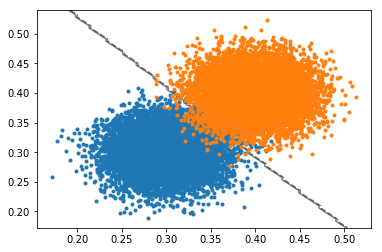

In [159]:
point_to_plot = 10000
plt.plot(class0_validate[0:point_to_plot,0], class0_validate[0:point_to_plot,1], '.')
plt.plot(class1_validate[0:point_to_plot,0], class1_validate[0:point_to_plot,1], '.')
plot_tn_decision_function(Tweight, ax=None)
plt.show()

### SVM

In [168]:
# Create SVM classification object 
model = svm.SVC(kernel='linear', C=4, gamma=1) 
model.fit(train_data, label)
svm_scored= model.score(validate_data, label_validate)
print("SVM Classification fidelity: "+str(svm_scored))

SVM Classification fidelity: 0.991


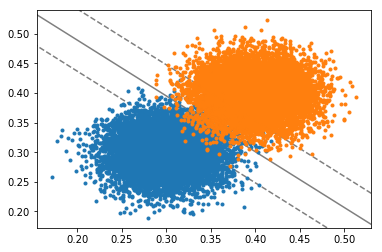

In [161]:
point_to_plot = 10000
plt.plot(class0_validate[0:point_to_plot,0], class0_validate[0:point_to_plot,1], '.')
plt.plot(class1_validate[0:point_to_plot,0], class1_validate[0:point_to_plot,1], '.')
plot_svc_decision_function(model)
plt.show()

## Naive Bayes

In [165]:
gnb = GaussianNB()
gnb.fit(train_data,label)
gnb.score(validate_data,label_validate)

0.99099999999999999

In [167]:
nb=nbayes()
nb.learn(train_data,label)
nb_scored=nb.score(validate_data,label_validate)
print("NB Classification fidelity: "+str(nb_scored))

Percentage: 0.991
NB Classification fidelity: 0.991


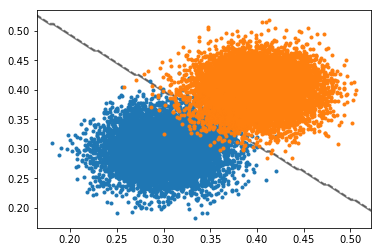

In [17]:
point_to_plot = 10000
plt.plot(class0_validate[0:point_to_plot,0], class0_validate[0:point_to_plot,1], '.')
plt.plot(class1_validate[0:point_to_plot,0], class1_validate[0:point_to_plot,1], '.')
plot_nb_decision_function(gnb)
plt.show()

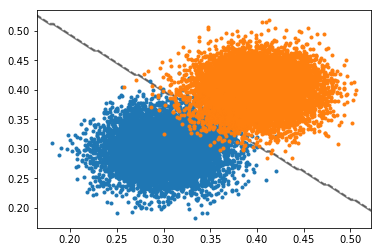

In [18]:
point_to_plot = 10000
plt.plot(class0_validate[0:point_to_plot,0], class0_validate[0:point_to_plot,1], '.')
plt.plot(class1_validate[0:point_to_plot,0], class1_validate[0:point_to_plot,1], '.')
plot_nb_decision_function(nb)
plt.show()

In [204]:
dataframe_gauss=pd.DataFrame([tn_scored,svm_scored,nb_scored],index=["TN","SVM","NB"],columns=["Gauss"] )
dataframe_gauss

,Gauss
TN,0.9925
SVM,0.9910
NB,0.9910


## Semi circular uniform distributions

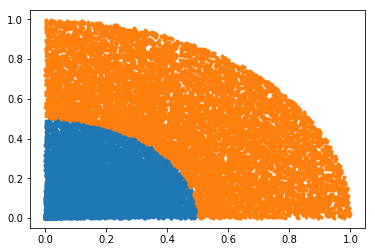

In [205]:
max_data = 10000
class0_radius = np.random.uniform(0, 0.5, max_data)
class0_phase = np.random.uniform(0, 0.5*np.pi, max_data)
class1_radius = np.random.uniform(0.5, 1, max_data)
class1_phase = np.random.uniform(0, 0.5*np.pi, max_data)

x0 = np.array([class0_radius*np.cos(class0_phase)])
y0 = np.array([class0_radius*np.sin(class0_phase)])
class0_learning = np.concatenate((x0.T, y0.T), axis=1)

x1 = np.array([class1_radius*np.cos(class1_phase)])
y1 = np.array([class1_radius*np.sin(class1_phase)])
class1_learning = np.concatenate((x1.T, y1.T), axis=1)

class0_radius_validate = np.random.uniform(0, 0.5, max_data)
class0_phase_validate = np.random.uniform(0, 0.5*np.pi, max_data)
class1_radius_validate = np.random.uniform(0.5, 1, max_data)
class1_phase_validate = np.random.uniform(0, 0.5*np.pi, max_data)

x0_validate = np.array([class0_radius_validate*np.cos(class0_phase_validate)])
y0_validate = np.array([class0_radius_validate*np.sin(class0_phase_validate)])
class0_validate = np.concatenate((x0_validate.T, y0_validate.T), axis=1)

x1_validate = np.array([class1_radius_validate*np.cos(class1_phase_validate)])
y1_validate = np.array([class1_radius_validate*np.sin(class1_phase_validate)])
class1_validate = np.concatenate((x1_validate.T, y1_validate.T), axis=1)

plt.plot(class0_learning[:,0], class0_learning[:,1], '.')
plt.plot(class1_learning[:,0], class1_learning[:,1], '.')
plt.show()

Prepare training data

In [206]:
# set data
numdata = 1000
train_data = np.concatenate([class0_learning[0:numdata], class1_learning[0:numdata]])
label = np.concatenate([np.array([0]*numdata), np.array([1]*numdata)])

validate_data=np.concatenate([class0_validate[0:numdata], class1_validate[0:numdata]])
label_validate=np.concatenate([np.array([0]*numdata), np.array([1]*numdata)])

### Tensor network

Generate and update a random tensor weight using gradient descent steps

In [207]:
d = 3
rng = np.random.RandomState(seed=143)
Tweight = mp.random_mpa(sites=1, ldim=[[2,d,d]], bdim=1, randstate=rng, normalized=True)

In [208]:
numsteps = 200
alpha = 1e-3 # control convergence

for idx in range(numsteps):
    Tweight = update2sites(train_data, label, Tweight)

In [209]:
tn_scored=tn_score(Tweight,validate_data,label_validate)
print("TN Classification fidelity: "+str(tn_scored))

TN Classification fidelity: 0.9785


Plot results

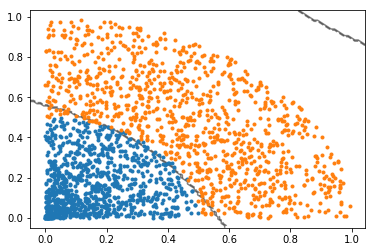

In [210]:
point_to_plot = 1000
plt.plot(class0_validate[0:point_to_plot,0], class0_validate[0:point_to_plot,1], '.')
plt.plot(class1_validate[0:point_to_plot,0], class1_validate[0:point_to_plot,1], '.')
plot_tn_decision_function(Tweight, ax=None)
plt.show()

### SVM

In [211]:
# Create SVM classification object 
model = svm.SVC(kernel='poly', C=4, gamma=1) 
model.fit(train_data, label)
svm_scored= model.score(validate_data, label_validate)
print("SVM Classification fidelity: "+str(svm_scored))

SVM Classification fidelity: 0.994


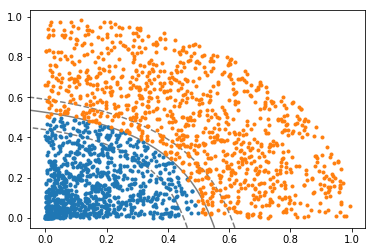

In [212]:
point_to_plot = 1000
plt.plot(class0_validate[0:point_to_plot,0], class0_validate[0:point_to_plot,1], '.')
plt.plot(class1_validate[0:point_to_plot,0], class1_validate[0:point_to_plot,1], '.')
plot_svc_decision_function(model)
plt.show()

### Naive Bayes

In [213]:
gnb = GaussianNB()
gnb.fit(train_data,label)
print(gnb.score(validate_data,label_validate))
nb=nbayes()
nb.learn(train_data,label)
nb_scored=nb.score(validate_data,label_validate)
print("NB Classification fidelity: "+str(nb_scored))

0.9495
Percentage: 0.9495
NB Classification fidelity: 0.9495


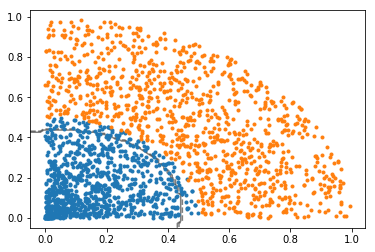

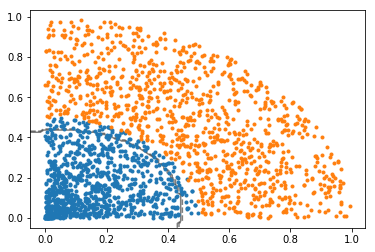

In [215]:
point_to_plot = 1000
plt.plot(class0_validate[0:point_to_plot,0], class0_validate[0:point_to_plot,1], '.')
plt.plot(class1_validate[0:point_to_plot,0], class1_validate[0:point_to_plot,1], '.')
plot_nb_decision_function(gnb)
plt.show()

point_to_plot = 1000
plt.plot(class0_validate[0:point_to_plot,0], class0_validate[0:point_to_plot,1], '.')
plt.plot(class1_validate[0:point_to_plot,0], class1_validate[0:point_to_plot,1], '.')
plot_nb_decision_function(nb)
plt.show()

In [216]:
dataframe_semi_circ=pd.DataFrame([tn_scored,svm_scored,nb_scored],index=["TN","SVM","NB"],columns=["Semi Circular"] )
dataframe_semi_circ

,Semi Circular
TN,0.9785
SVM,0.9940
NB,0.9495


## Circular distribution

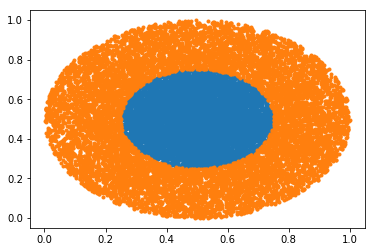

In [217]:
max_data = 10000
class0_radius = np.random.uniform(0, 0.5, max_data)
class0_phase = np.random.uniform(0, 2*np.pi, max_data)
class1_radius = np.random.uniform(0.5, 1, max_data)
class1_phase = np.random.uniform(0, 2*np.pi, max_data)

x0 = np.array([class0_radius*np.cos(class0_phase)]) * 0.5 + 0.5
y0 = np.array([class0_radius*np.sin(class0_phase)]) * 0.5 + 0.5
class0_learning = np.concatenate((x0.T, y0.T), axis=1)

x1 = np.array([class1_radius*np.cos(class1_phase)]) * 0.5 + 0.5
y1 = np.array([class1_radius*np.sin(class1_phase)]) * 0.5 + 0.5
class1_learning = np.concatenate((x1.T, y1.T), axis=1)

class0_radius_validate = np.random.uniform(0, 0.5, max_data)
class0_phase_validate = np.random.uniform(0, 2*np.pi, max_data)
class1_radius_validate = np.random.uniform(0.5, 1, max_data)
class1_phase_validate = np.random.uniform(0, 2*np.pi, max_data)

x0_validate = np.array([class0_radius_validate*np.cos(class0_phase_validate)]) * 0.5 + 0.5
y0_validate = np.array([class0_radius_validate*np.sin(class0_phase_validate)]) * 0.5 + 0.5
class0_validate = np.concatenate((x0_validate.T, y0_validate.T), axis=1)

x1_validate = np.array([class1_radius_validate*np.cos(class1_phase_validate)]) * 0.5 + 0.5
y1_validate = np.array([class1_radius_validate*np.sin(class1_phase_validate)]) * 0.5 + 0.5
class1_validate = np.concatenate((x1_validate.T, y1_validate.T), axis=1)


plt.plot(class0_learning[:,0], class0_learning[:,1], '.')
plt.plot(class1_learning[:,0], class1_learning[:,1], '.')
plt.show()

Prepare training data

In [218]:
# set data
numdata = 1000
train_data = np.concatenate([class0_learning[0:numdata], class1_learning[0:numdata]])
label = np.concatenate([np.array([0]*numdata), np.array([1]*numdata)])

validate_data=np.concatenate([class0_validate[0:numdata], class1_validate[0:numdata]])
label_validate=np.concatenate([np.array([0]*numdata), np.array([1]*numdata)])

### Tensor network

Generate and update a random tensor weight using gradient descent steps

In [219]:
d = 3
rng = np.random.RandomState(seed=143)
Tweight = mp.random_mpa(sites=1, ldim=[[2,d,d]], bdim=1, randstate=rng, normalized=True)

In [220]:
numsteps = 200
alpha = 1e-3 # control convergence

for idx in range(numsteps):
    Tweight = update2sites(train_data, label, Tweight)

In [221]:
tn_scored=tn_score(Tweight,validate_data,label_validate)
print("TN Classification fidelity: "+str(tn_scored))

TN Classification fidelity: 0.939


Plot results

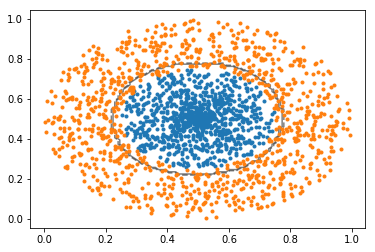

In [222]:
point_to_plot = 1000
plt.plot(class0_validate[0:point_to_plot,0], class0_validate[0:point_to_plot,1], '.')
plt.plot(class1_validate[0:point_to_plot,0], class1_validate[0:point_to_plot,1], '.')
plot_tn_decision_function(Tweight, ax=None)
plt.show()

### SVM

In [223]:
# Create SVM classification object 
model = svm.SVC(kernel='rbf', C=4, gamma=1) 
model.fit(train_data, label)
svm_scored= model.score(validate_data, label_validate)
print("SVM Classification fidelity: "+str(svm_scored))

SVM Classification fidelity: 0.988


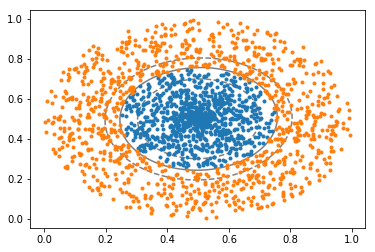

In [224]:
point_to_plot = 1000
plt.plot(class0_validate[0:point_to_plot,0], class0_validate[0:point_to_plot,1], '.')
plt.plot(class1_validate[0:point_to_plot,0], class1_validate[0:point_to_plot,1], '.')
plot_svc_decision_function(model)
plt.show()

### Naive Bayes

In [225]:
gnb = GaussianNB()
gnb.fit(train_data,label)
print(gnb.score(validate_data,label_validate))
nb=nbayes()
nb.learn(train_data,label)
nb_scored=nb.score(validate_data,label_validate)
print("NB Classification fidelity: "+str(nb_scored))

0.941
Percentage: 0.941
NB Classification fidelity: 0.941


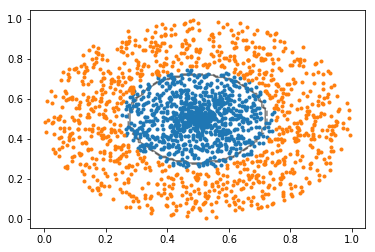

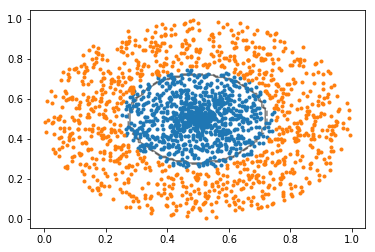

In [226]:
point_to_plot = 1000
plt.plot(class0_validate[0:point_to_plot,0], class0_validate[0:point_to_plot,1], '.')
plt.plot(class1_validate[0:point_to_plot,0], class1_validate[0:point_to_plot,1], '.')
plot_nb_decision_function(gnb)
plt.show()

point_to_plot = 1000
plt.plot(class0_validate[0:point_to_plot,0], class0_validate[0:point_to_plot,1], '.')
plt.plot(class1_validate[0:point_to_plot,0], class1_validate[0:point_to_plot,1], '.')
plot_nb_decision_function(nb)
plt.show()

In [227]:
dataframe_circ=pd.DataFrame([tn_scored,svm_scored,nb_scored],index=["TN","SVM","NB"],columns=["Circular"] )
dataframe_circ

,Circular
TN,0.939
SVM,0.988
NB,0.941


## Spiral distributions

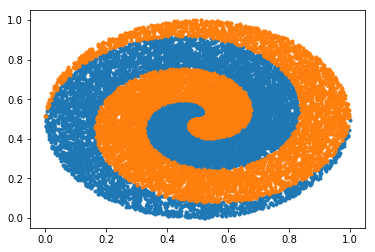

In [228]:
max_data = 10000
max_angle = 3*np.pi
theta = np.random.uniform(0, max_angle, max_data)

class0_phase = np.random.uniform(0, np.pi, max_data)
class1_phase = np.random.uniform(0, -np.pi, max_data)

x0 = np.array([theta * np.cos(theta + class0_phase)]) * 0.5 / max_angle + 0.5
y0 = np.array([theta * np.sin(theta + class0_phase)]) * 0.5 / max_angle + 0.5
class0_learning = np.concatenate((x0.T, y0.T), axis=1)

x1 = np.array([theta * np.cos(theta + class1_phase)]) * 0.5 / max_angle + 0.5
y1 = np.array([theta * np.sin(theta + class1_phase)]) * 0.5 / max_angle + 0.5
class1_learning = np.concatenate((x1.T, y1.T), axis=1)

theta_validate = np.random.uniform(0, max_angle, max_data)

class0_phase_validate = np.random.uniform(0, np.pi, max_data)
class1_phase_validate = np.random.uniform(0, -np.pi, max_data)

x0_validate = np.array([theta_validate * np.cos(theta_validate + class0_phase_validate)]) * 0.5 / max_angle + 0.5
y0_validate = np.array([theta_validate * np.sin(theta_validate + class0_phase_validate)]) * 0.5 / max_angle + 0.5
class0_validate = np.concatenate((x0_validate.T, y0_validate.T), axis=1)

x1_validate = np.array([theta_validate * np.cos(theta_validate + class1_phase_validate)]) * 0.5 / max_angle + 0.5
y1_validate = np.array([theta_validate * np.sin(theta_validate + class1_phase_validate)]) * 0.5 / max_angle + 0.5
class1_validate = np.concatenate((x1_validate.T, y1_validate.T), axis=1)

plt.plot(class0_learning[:,0], class0_learning[:,1], '.')
plt.plot(class1_learning[:,0], class1_learning[:,1], '.')
plt.show()


Prepare training data

In [229]:
# set data
numdata = 1000
train_data = np.concatenate([class0_learning[0:numdata], class1_learning[0:numdata]])
label = np.concatenate([np.array([0]*numdata), np.array([1]*numdata)])

validate_data=np.concatenate([class0_validate[0:numdata], class1_validate[0:numdata]])
label_validate=np.concatenate([np.array([0]*numdata), np.array([1]*numdata)])

### Tensor network

Generate and update a random tensor weight using gradient descent steps

In [230]:
d = 70
rng = np.random.RandomState(seed=143)
Tweight = mp.random_mpa(sites=1, ldim=[[2,d,d]], bdim=1, randstate=rng, normalized=True)

In [231]:
numsteps = 100
alpha = 1e-3 # control convergence

for idx in range(numsteps):
    Tweight = update2sites(train_data, label, Tweight)

In [232]:
tn_scored=tn_score(Tweight,validate_data,label_validate)
print("TN Classification fidelity: "+str(tn_scored))

TN Classification fidelity: 0.9465


Plot results

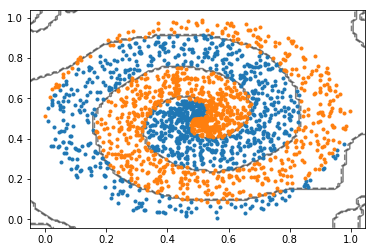

In [240]:
point_to_plot = 1000
plt.plot(class0_validate[0:point_to_plot,0], class0_validate[0:point_to_plot,1], '.')
plt.plot(class1_validate[0:point_to_plot,0], class1_validate[0:point_to_plot,1], '.')
plot_tn_decision_function(Tweight, ax=None)
plt.show()

### SVM

In [234]:
# Create SVM classification object 
model = svm.SVC(kernel='rbf', C=4, gamma=1) 
model.fit(train_data, label)
svm_scored= model.score(validate_data, label_validate)
print("SVM Classification fidelity: "+str(svm_scored))

SVM Classification fidelity: 0.5495


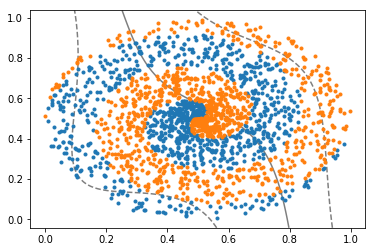

In [235]:
point_to_plot = 1000
plt.plot(class0_validate[0:point_to_plot,0], class0_validate[0:point_to_plot,1], '.')
plt.plot(class1_validate[0:point_to_plot,0], class1_validate[0:point_to_plot,1], '.')
plot_svc_decision_function(model)
plt.show()

### Naive Bayes

In [236]:
gnb = GaussianNB()
gnb.fit(train_data,label)
print(gnb.score(validate_data,label_validate))
nb=nbayes()
nb.learn(train_data,label)
nb_scored=nb.score(validate_data,label_validate)
print("NB Classification fidelity: "+str(nb_scored))

0.5585
Percentage: 0.5585
NB Classification fidelity: 0.5585


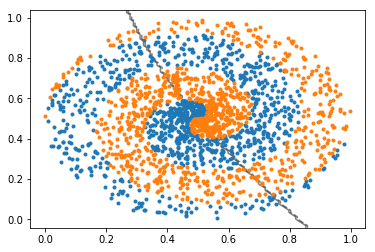

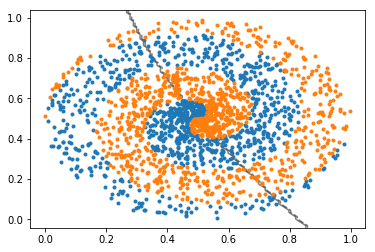

In [237]:
point_to_plot = 1000
plt.plot(class0_validate[0:point_to_plot,0], class0_validate[0:point_to_plot,1], '.')
plt.plot(class1_validate[0:point_to_plot,0], class1_validate[0:point_to_plot,1], '.')
plot_nb_decision_function(gnb)
plt.show()

point_to_plot = 1000
plt.plot(class0_validate[0:point_to_plot,0], class0_validate[0:point_to_plot,1], '.')
plt.plot(class1_validate[0:point_to_plot,0], class1_validate[0:point_to_plot,1], '.')
plot_nb_decision_function(nb)
plt.show()

In [238]:
dataframe_spiral=pd.DataFrame([tn_scored,svm_scored,nb_scored],index=["TN","SVM","NB"],columns=["Spiral"] )
dataframe_spiral

,Spiral
TN,0.9465
SVM,0.5495
NB,0.5585


# Summary

In [239]:
pd.concat([dataframe_gauss,dataframe_semi_circ,dataframe_circ,dataframe_spiral],axis=1)

,Gauss,Semi Circular,Circular,Spiral
TN,0.9925,0.9785,0.939,0.9465
SVM,0.9910,0.9940,0.988,0.5495
NB,0.9910,0.9495,0.941,0.5585


# Real Sweeeeeping!

In [5]:
@autojit
def feature_map(x):
    """Local feature map"""
    
    x_arr = 0.5 * np.pi * np.array([x]*d)
    s = np.arange(d)
    return np.sqrt(binom([d-1]*d,s)) * np.power(np.cos(x_arr), d-1-s) * np.power(np.sin(x_arr), s)

@autojit
def Tdelta(l):
    """Create a tensor kronecker delta"""
    return mp.MPArray.from_kron([np.array([1-l,l])])

@autojit
def evaluate(Tweight, x, y, z):
    xyz_mpa = mp.MPArray.from_kron([feature_map(x),feature_map(y),feature_map(z)]).group_sites(3) # feature tensor
    Tweight = Tweight.group_sites(3)
    Tf = mp.dot(Tweight,xyz_mpa,axes=([1,2,3],[0,1,2]))
    W0 = mp.dot(Tf, Tdelta(0)).to_array()
    W1 = mp.dot(Tf, Tdelta(1)).to_array()
    Wdiff = W0 - W1
    Wsum = W0 + W1
    return Wdiff * Wsum / np.abs(Wdiff * Wsum)

def tn_decision_function(Tweight, class0, class1):
    val0 = []
    for v0 in class0:
        val0.append(evaluate(Tweight, v0[0], v0[1], v0[2]))
    
    val1 = []
    for v1 in class1:
        val1.append(evaluate(Tweight, v1[0], v1[1], v1[2]))
    
    return val0, val1
    

In [ ]:
d = 2
m = 1
l = 1
sites = 3

rng = np.random.RandomState(seed=143)
ldim = [[d]]*(sites-1)
ldim.append([l,d])
Tweight = mp.random_mpa(sites=sites, ldim=ldim[::-1], bdim=m, randstate=rng, normalized=True)
print(Tweight.pdims)
print(Tweight.bdims)
print(Tweight.to_array())
a,b=Tweight.split(0)
print('---')
print(a.pdims)
print(a.to_array())
print(b.pdims)
print(b.to_array())
r=mp.dot(a,b.group_sites(2),axes=(2,0))

print(r.pdims)
print(r.to_array())


In [3]:
#two gaussians 3D
mean1=[0.3,0.3,0.3]
cov1=[[0.001,0,0],[0,0.001,0],[0,0,0.001]]
mean2=[0.4,0.4,0.4]
cov2=[[0.001,0,0],[0,0.001,0],[0,0,0.001]]
class0=np.random.multivariate_normal(mean1, cov1, 1)
class1=np.random.multivariate_normal(mean2, cov2, 1)

trace1 = Scatter3d(
    x=class0.T[0],
    y=class0.T[1],
    z=class0.T[2],
    mode='markers',
    marker=dict(
        size=3,
        symbol = "cross",
        line=dict(
            width=0.5
        )
    )
)
trace2 = Scatter3d(
    x=class1.T[0],
    y=class1.T[1],
    z=class1.T[2],
    mode='markers',
    marker=dict(
        #color='rgb(127, 127, 127)',
        size=3,
        symbol='circle',
        line=dict(
            width=1
        )
    )
)

data_plot = [trace1, trace2]
layout = Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = Figure(data=data_plot, layout=layout)
ply.plot(fig, filename='simple-3d-scatter')

/home/luca/anaconda3/lib/python3.6/site-packages/plotly/offline/offline.py:459: UserWarning:

Your filename `simple-3d-scatter` didn't end with .html. Adding .html to the end of your file.



'file:///home/luca/Dottorato/Cisas/Corsi/BML/esame/TN-BML/simple-3d-scatter.html'

In [ ]:
def split_sites(mpa, site_label):
    """Split physical legs of the site site_label so to have one leg per site"""
    
    max_num_site = len(t1)
    if site_label > max_num_site - 1:
        print("Site does not exist")
        return
    if site_label < 0:
        print("site must be non negative")
        return
    
    if site_label > 0:
        mpa_left, mpa_center = mpa.split(site_label - 1)
    else:
        mpa_center = mpa
        mpa_left = []
        
    if site_label < max_num_site - 1:
        mpa_center, mpa_right = mpa_center.split(0)
    else:
        mpa_right = []
    
    mpa_center_nlegs = mpa_center.plegs[0]
    mpa_center = mpa_center.split_sites(mpa_center.plegs[0])
    mpa_list = [mpa_left, mpa_center, mpa_right]
    mpa_list = [x for x in mpa_list if x]        # get rid of empty list
    mpa_splitted = mp.outer(mpa_list)
    
    if site_label < max_num_site - 1:
        mpa_splitted = mpa_splitted.pleg2bleg(site_label - 1 + mpa_center_nlegs)
    if site_label > 0:
        mpa_splitted = mpa_splitted.pleg2bleg(site_label - 1)

    return mp.prune(mpa_splitted)

In [ ]:
rng = np.random.RandomState(seed=143)
t1=mp.random_mpa(sites=2, ldim=[[3,4],[4,2]], bdim=2, randstate=rng, normalized=True)
site_to_split=1
print(t1.pdims)
mpa = split_sites(t1,site_to_split)
print(mpa.pdims)
print(mpa.reverse().pdims)

In [7]:
#two gaussians 4D
mean1=[0.3,0.3,0.3,0.3]
cov1=[[0.001,0,0,0],[0,0.001,0,0],[0,0,0.001,0],[0,0,0,0.001]]
mean2=[0.4,0.4,0.4,0.4]
cov2=[[0.001,0,0,0],[0,0.001,0,0],[0,0,0.001,0],[0,0,0,0.001]]
class0=np.random.multivariate_normal(mean1, cov1, 100)
class1=np.random.multivariate_normal(mean2, cov2, 100)

@autojit
def Tdelta(l):
    """Create a tensor kronecker delta"""
    return mp.MPArray.from_kron([np.array([1-l,l,0])])

d = 4
m = 2
l = 3
sites = 3
alpha = 0.1

rng = np.random.RandomState(seed=143)
ldim = [[d]]*(sites-1)
ldim.append([l,d])
TW = mp.random_mpa(sites=sites, ldim=ldim[::-1], bdim=m, randstate=rng, normalized=True)

numdata = 10
train_data = np.concatenate([class0[0:numdata],class1[0:numdata]])
label = np.concatenate([np.array([0]*numdata),np.array([1]*numdata)])

#bond 0  
bond = 0
B, TW_right = TW.split(1)
B = B.group_sites(2)
TdeltaB = mp.MPArray.from_kron([np.array([0]*l), np.array([0]*d), np.array([0]*d), np.array([0]*m)]).group_sites(4) #null tensor deltaB (single size
for idx in range(2):
    TPhi = mp.MPArray.from_kron([feature_map(train_data[idx][0]), feature_map(train_data[idx][1])]) # feature tensor
    TPhi_right = mp.MPArray.from_kron([feature_map(train_data[idx][n_site]) for n_site in range(2, sites)])

    TWPhi_right = mp.prune(mp.dot(TW_right, TPhi_right, axes=(-1,0)))
    TPhiTilde = mp.outer([TPhi, TWPhi_right]).group_sites(3)
    
    Tf = mp.prune(mp.dot(B, TPhiTilde, axes=([1,2,3],[0,1,2])))
    
    Tcoef = (Tdelta(label[idx]) - Tf)
    Ttemp = mp.outer([Tcoef, TPhiTilde]).group_sites(2)
    TdeltaB = TdeltaB + Ttemp

B = B + alpha * TdeltaB

B = B.transpose([1,0,2,3])
B = B.split_sites(4)
Bl, Br = B.split(0)
Br = Br.group_sites(3)
Bsvd = mp.outer([Bl,Br]).pleg2bleg(0)
Bsvd.compress(method='svd', bdim=m)

#bond 1
bond = 1
TW_left, Bl = Bsvd.split(0)
B = mp.prune(mp.outer([Bl,TW_right]).pleg2bleg(0)).group_sites(2)

TdeltaB = mp.MPArray.from_kron([np.array([0]*m), np.array([0]*l), np.array([0]*d), np.array([0]*d)]).group_sites(4) #null tensor deltaB (single size
for idx in range(2):
    TPhi = mp.MPArray.from_kron([feature_map(train_data[idx][1]), feature_map(train_data[idx][2])]) # feature tensor
    TPhi_left = mp.MPArray.from_kron([feature_map(train_data[idx][0])])

    TWPhi_left = mp.prune(mp.dot(TW_left, TPhi_left, axes=(0,0)))
    TPhiTilde = mp.outer([TWPhi_left, TPhi]).group_sites(3)
    
    Tf = mp.prune(mp.dot(B, TPhiTilde, axes=([0,2,3],[0,1,2])))
    
    Tcoef = (Tdelta(label[idx]) - Tf)
    Ttemp = mp.outer([Tcoef, TPhiTilde]).group_sites(2).transpose([1,0,2,3])
    TdeltaB = TdeltaB + Ttemp

B = B + alpha * TdeltaB
B = B.transpose([0,2,1,3])
B = B.split_sites(4)
Bl, Br = B.split(1)
Bl = Bl.group_sites(2)
Br = Br.group_sites(2)
Bsvd = mp.outer([Bl,Br]).pleg2bleg(0)
Bsvd.compress(method='svd', bdim=m)

TW = mp.outer([TW_left,Bsvd]).pleg2bleg(0)
TW = TW.reverse()

# update Weight with reversed algorithm
#bond 0  
bond = 0
B, TW_right = TW.split(1)
B = B.group_sites(2)
TdeltaB = mp.MPArray.from_kron([np.array([0]*l), np.array([0]*d), np.array([0]*d), np.array([0]*m)]).group_sites(4) #null tensor deltaB (single size
for idx in range(2):
    TPhi = mp.MPArray.from_kron([feature_map(train_data[idx][2]), feature_map(train_data[idx][1])]) # feature tensor
    TPhi_right = mp.MPArray.from_kron([feature_map(train_data[idx][n_site]) for n_site in range(2, sites)])

    TWPhi_right = mp.prune(mp.dot(TW_right, TPhi_right, axes=(-1,0)))
    TPhiTilde = mp.outer([TPhi, TWPhi_right]).group_sites(3)
    
    Tf = mp.prune(mp.dot(B, TPhiTilde, axes=([1,2,3],[0,1,2])))
    
    Tcoef = (Tdelta(label[idx]) - Tf)
    Ttemp = mp.outer([Tcoef, TPhiTilde]).group_sites(2)
    TdeltaB = TdeltaB + Ttemp

B = B + alpha * TdeltaB
B = B.transpose([1,0,2,3])
B = B.split_sites(4)
Bl, Br = B.split(0)
Br = Br.group_sites(3)
Bsvd = mp.outer([Bl,Br]).pleg2bleg(0)
Bsvd.compress(method='svd', bdim=m)

#bond 1
bond = 1
TW_left, Bl = Bsvd.split(0)
B = mp.prune(mp.outer([Bl,TW_right]).pleg2bleg(0)).group_sites(2)

TdeltaB = mp.MPArray.from_kron([np.array([0]*m), np.array([0]*l), np.array([0]*d), np.array([0]*d)]).group_sites(4) #null tensor deltaB (single size
for idx in range(2):
    TPhi = mp.MPArray.from_kron([feature_map(train_data[idx][1]), feature_map(train_data[idx][0])]) # feature tensor
    TPhi_left = mp.MPArray.from_kron([feature_map(train_data[idx][0])])

    TWPhi_left = mp.prune(mp.dot(TW_left, TPhi_left, axes=(0,0)))
    TPhiTilde = mp.outer([TWPhi_left, TPhi]).group_sites(3)
    
    Tf = mp.prune(mp.dot(B, TPhiTilde, axes=([0,2,3],[0,1,2])))
    
    Tcoef = (Tdelta(label[idx]) - Tf)
    Ttemp = mp.outer([Tcoef, TPhiTilde]).group_sites(2).transpose([1,0,2,3])
    TdeltaB = TdeltaB + Ttemp

B = B + alpha * TdeltaB
B = B.transpose([0,2,1,3])
B = B.split_sites(4)
Bl, Br = B.split(1)
Bl = Bl.group_sites(2)
Br = Br.group_sites(2)
Bsvd = mp.outer([Bl,Br]).pleg2bleg(0)
Bsvd.compress(method='svd', bdim=m)

TW = mp.outer([TW_left,Bsvd]).pleg2bleg(0)
TW = TW.reverse()

#mpa2 = mp.MPArray.from_kron([np.array([1,0,0,0]),np.array([1,0,0,0]),np.array([1,0,0,0])])
#a=mp.dot(TW, mpa2)
#print(TdeltaB.pdims)
print(TW.pdims)

((3, 4), (4,), (4,))


In [20]:
#two gaussians 3D
d = 4
m = 2
l = 3
sites = 3
alpha = 0.1

rng = np.random.RandomState(seed=143)
ldim = [[d]]*(sites-1)
ldim.append([l,d])
#TW = mp.random_mpa(sites=sites, ldim=ldim[::-1], bdim=m, randstate=rng, normalized=True)

mean1=[0.3,0.3,0.3]
cov1=[[0.001,0,0],[0,0.001,0],[0,0,0.001]]
mean2=[0.4,0.4,0.4]
cov2=[[0.001,0,0],[0,0.001,0],[0,0,0.001]]
class0=np.random.multivariate_normal(mean1, cov1, 1000)
class1=np.random.multivariate_normal(mean2, cov2, 1000)

cl0, cl1 = tn_decision_function(TW, class0, class1)

trace1 = Scatter3d(
    x=class0.T[0],
    y=class0.T[1],
    z=class0.T[2],
    mode='markers',
    marker=dict(
        size=10,
        symbol = "circle",
        cmax=39,
        cmin=0,
        color = np.ones(len(cl0)),#(np.array(cl0) + 1)*0,
        colorscale=[[0, 'rgb(0,0,255)'], [0.5, 'rgb(0,0,255)'], [0.5, 'rgb(255,0,0)'], [1, 'rgb(255,0,0)']],
        colorbar = {
            'tick0': 0,
            'dtick': 1
        },
        line=dict(
            width=0.5
        )
    )
)
trace2 = Scatter3d(
    x=class1.T[0],
    y=class1.T[1],
    z=class1.T[2],
    mode='markers',
    marker=dict(
        #color='rgb(127, 127, 127)',
        size=3,
        symbol='circle',
        line=dict(
            width=1
        )
    )
)

data_plot = [trace1]#, trace2]
layout = Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = Figure(data=data_plot, layout=layout)
ply.plot(fig, filename='simple-3d-scatter')

/home/luca/anaconda3/lib/python3.6/site-packages/plotly/offline/offline.py:459: UserWarning:

Your filename `simple-3d-scatter` didn't end with .html. Adding .html to the end of your file.



'file:///home/luca/Dottorato/Cisas/Corsi/BML/esame/TN-BML/simple-3d-scatter.html'